In [1]:
from Bio import Entrez, SeqIO, AlignIO
from pathlib import Path
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

In [2]:
def buscar_genoma(nome_virus):
    
    Entrez.email = "computandocombiopy@gmail.com"
    termo_de_busca = f"{nome_virus} complete genome"
    busca = Entrez.esearch (db = "nucleotide", term = termo_de_busca, retmax = 1, sort = "relevance")
    resultado = Entrez.read(busca)
    busca.close()
    
    lista_ids = (resultado["IdList"])

    if not lista_ids:
        print(f"Não há um vírus {nome_virus} no NCBI. Tente outra vez!")

    id_do_virus = lista_ids[0]

    resumo = Entrez.esummary(db="nucleotide", id=id_do_virus)
    dados = Entrez.read(resumo)
    resumo.close()

    acession = dados[0]["AccessionVersion"]

    print(acession)

    return acession
    

   

In [3]:
def baixar_genoma(iden, output_folder=Path("data")/"genomes", output_file=Path("data/genomes/todos_genomas.fasta"), limite_pb=3000):
    Entrez.email = "computandocombiopy@gmail.com"
    output_file.parent.mkdir(parents=True, exist_ok=True)
    output_folder.mkdir(parents=True, exist_ok=True)
    filename=output_folder/f"{iden}.fasta"
    
    try:
        # Baixa o genoma completo em formato FASTA
        handle = Entrez.efetch(db="nucleotide", id=iden, rettype="fasta", retmode="text", sort = "lenght")
        fasta_texto = handle.read()
        handle.close()

        if not fasta_texto:
            print("Error: Resposta vazia do NCBI")
        else: 
            with open(filename, "w") as output:
                output.write(fasta_texto)
            print(f"Salvo em {filename}")

        if not fasta_texto.strip():
            print(f"Nenhum dado retornado para {iden}")
            return
        
        # Lê o conteúdo como um objeto SeqRecord
        seq_io = StringIO(fasta_texto)
        record = SeqIO.read(seq_io, "fasta")

        # Trunca a sequência para no máximo 3000 pb
        record.seq = record.seq[:limite_pb]

        # Escreve em um arquivo FASTA único (modo append)
        with open(output_file, "a") as output_handle:
            SeqIO.write(record, output_handle, "fasta")

        print(f"{iden} salvo (limitado a {limite_pb} pb) em {output_file}")

    except Exception as e:
        print(f"Erro ao processar {iden}: {e}")

In [4]:
def rodar_muscle(entrada_fasta, saida_fasta): 
    
    # Acessa o executável do MUSCLE
    muscle_exe = "muscle-win64.v5.3.exe"
    
    # Alinha o arquivo de entrada e coloca os dados de saída no arquivo criado pelo executável
    comando = [muscle_exe, "-align", entrada_fasta, "-output", saida_fasta]
    
    # Tratamento de erro
    try: 
        resultado = subprocess.run(comando, check=True, capture_output=True, text=True) 
        print("MUSCLE finalizado com sucesso.")
        print("STDOUT:", resultado.stdout)
        print("STDERR:", resultado.stderr)
    except subprocess.CalledProcessError as e:
        print("Erro ao rodar MUSCLE:")
        print("STDOUT:", e.stdout)
        print("STDERR:", e.stderr)
        
        # Imprime o erro novamente, além de interromper o programa, impedindo que o erro se prolongue
        raise 

In [5]:
def calcular_similaridades(alinhado_fasta):
    entrada = AlignIO.read(alinhado_fasta, "fasta")

    seqs = []
    nomes = []

    for reg in entrada:
        seqs.append(str(reg.seq))
        nomes.append(reg.id)

    n = len(seqs)

    matriz = np.full((n, n), 0, dtype = float)

    for virus1 in range(n):
        for virus2 in range(n):
            bases_iguais = sum(a==b for a,b in zip(seqs[virus1], seqs[virus2]))
            total_bases = len(seqs[virus1])
            if total_bases > 0:
                similaridade = bases_iguais / total_bases
            else:
                similaridade = 0
            matriz[virus1, virus2] = similaridade
    
    return nomes, matriz

In [12]:
from collections import defaultdict
import os
#Obtendo todos arquivos da pasta genomes (retorna uma lista com objetos path)
def obtendo_fasta(fasta_dir: Path) -> list[Path]:
  #Checando se o diretório existe ou não
  if not fasta_dir.exists():
    raise FileNotFoundError(f"Diretório de arquivos FASTA não encontrado: {fasta_dir}")
#verificação dupla agora de se é realmente um diretório e não um arquvio
  if not fasta_dir.is_dir():
    raise NotADirectoryError(f"O caminho não é um diretório: {fasta_dir}")
  return list(fasta_dir.glob('*.fasta'))+list(fasta_dir.glob('*.FASTA'))

  
def calculo_dist(fasta_file: Path):
  #inicializo como defaultdict (me ajuda a manejar o dicionário, execução
  #+rápida)
  contador_bases=defaultdict(int)
  total_bases=0
  """A função calcula a porcentagem de bases em uma sequência de RNA.
  Os retornos são (percentual_gc, {'A':x%, 'U':y%, 'C':z%, 'G':w%})
  """
  #Abro o arquivo e chamo de f
  with open(fasta_file, 'r') as f:
    for linha in f:
      if linha.startswith('>'):
          continue
    #Por que strip() e upper? Retiro qualquer espaço ou caracter de linha nova
    #Converto tudo pra maiúsculo.
      for base in linha.strip().upper():
        #PARA RNA PELO AMOR
        if base in 'ACGUT':
          contador_bases[base]+=1
          total_bases+=1

  base_percentuais={
    base:(count/total_bases)*100 
    for base, count in contador_bases.items()
  }

  perc_gc= base_percentuais.get('G', 0) + base_percentuais.get('C',0)
  
  return perc_gc, base_percentuais
  
def calculando_distribuicoes():
  porcentagensCG={}
  lista_porcentagens={}
  #Obtendo o caminho em que esse código está sendo executado
  raiz_projeto = Path(os.getcwd())

  #Encontro o caminho para a pasta genomes que tem os arquivos .fasta
  fasta_dir= raiz_projeto / "data/genomes"

  try: 
    #Obtenho todos os arquivos que vem do diretório 
    fasta_files=obtendo_fasta(fasta_dir)

    #Quero saber se eu puxei os arquivos do diretório:
    if not fasta_files:
      print(f"Sem arquivos fasta em {fasta_dir}")
      #Sai do código prematuramente (não tinha nada, tem que sair)
      return
    #Achei arquivos!!
    print(f"Encontrados arquivos .fasta")

    #Percorro os arquivos e adiciono nos dicionários um par
    #código do virus/porcentagemC e codigo do virus/lista_porcentagens
    for fasta_file in fasta_files:
      #perc_cg tem a porcentagem de CG e lista_perc tem as porcentagens de cada
      #par de base
      if fasta_file.stem != "todos_genomas":
        perc_gc, lista_perc=calculo_dist(fasta_file)
        porcentagensCG[fasta_file.stem]=perc_gc
        lista_porcentagens[fasta_file.stem]=lista_perc

  except Exception as e:
    print(f"Erro {str(e)}", file=sys.stderr)
    sys.exit(1)
      
  return porcentagensCG, lista_porcentagens

In [7]:
def plotar_matriz_triangular(nomes, matriz):

    # Garante que a matriz é um array NumPy, necessário para facilitar as operações matemáticas e criação de gráficos
    matriz_np = np.array(matriz) 
    
    # Máscara para esconder a parte superior da matriz (acima da diagonal)
    matriz_bool = np.ones_like(matriz_np, dtype=bool)
    mascara = np.triu(matriz_bool)
    
    # Módulo para criar uma figura com tamanho definido em polegadas (largura, altura)
    plt.figure(figsize=(8, 6)) 
    sns.heatmap(matriz_np, annot=True, fmt=".2f", mask=mascara,
                xticklabels=nomes, yticklabels=nomes,
                cmap="YlGnBu", linewidths=0.5, cbar_kws={"label": "Similaridade"},
                vmin=0.001, vmax=1.0)

    plt.title("Matriz de Similaridade Genômica", fontsize=16)
    plt.xticks(rotation=45, ha='right') 
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

Baixando o genoma de Zika
MW015936.1
Baixando o genoma de ebola
NC_002549.1
Baixando o genoma de dengue
AB189128.1
Salvo em data\genomes\MW015936.1.fasta
MW015936.1 salvo (limitado a 3000 pb) em data\genomes\todos_genomas.fasta
Salvo em data\genomes\NC_002549.1.fasta
NC_002549.1 salvo (limitado a 3000 pb) em data\genomes\todos_genomas.fasta
Salvo em data\genomes\AB189128.1.fasta
AB189128.1 salvo (limitado a 3000 pb) em data\genomes\todos_genomas.fasta
MUSCLE finalizado com sucesso.
STDOUT: 
STDERR: 
muscle 5.3.win64 [d9725ac]  16.6Gb RAM, 14 cores
Built Nov 10 2024 22:59:05
(C) Copyright 2004-2021 Robert C. Edgar.
https://drive5.com

[align data/genomes/todos_genomas.fasta]
Input: 3 seqs, avg length 3000, max 3000, min 3000

00:00 4.7Mb    33.3% Derep 1 uniques, 0 dupes
00:00 4.7Mb   100.0% Derep 3 uniques, 0 dupes

00:00 4.7Mb  CPU has 14 cores, running 14 threads
00:00 5.1Mb    33.3% Calc posteriors
00:00 2.2Gb   100.0% Calc posteriors

00:02 6.1Mb    50.0% UPGMA5         
00:02 6.1M

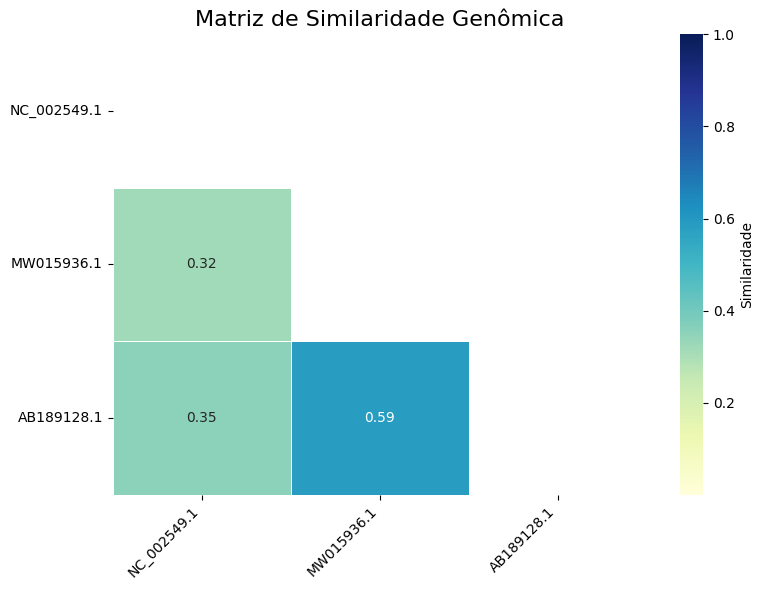

Encontrados arquivos .fasta
Porcentagens de G+C em cada genoma:
  AB189128.1: 46.88%
  MW015936.1: 51.32%
  NC_002549.1: 41.07%

Composição dos genomas por percentual de bases:
  AB189128.1:
    A: 32.05%
    G: 26.01%
    T: 21.07%
    C: 20.86%
  MW015936.1:
    A: 27.31%
    G: 29.25%
    T: 21.38%
    C: 22.07%
  NC_002549.1:
    C: 21.28%
    G: 19.79%
    A: 31.97%
    T: 26.96%


In [13]:
def comparar_genomas_geral(nome_virus):

    lista_acessions = []

    output_file = Path("data/genomes/todos_genomas.fasta")
    output_file.unlink(missing_ok=True)  # Remove o arquivo se existir

    for virus in nome_virus:
        print(f"Baixando o genoma de {virus}")
        lista_acessions.append(buscar_genoma(virus))
    for iden in lista_acessions:
        baixar_genoma(iden)
        
    rodar_muscle("data/genomes/todos_genomas.fasta", "data/genomes/genomas_alinhados")
    nomes, matriz = calcular_similaridades("data/genomes/genomas_alinhados")
    plotar_matriz_triangular(nomes, matriz)
    porcentagensCG, lista_porcentagens=calculando_distribuicoes()
    print("Porcentagens de G+C em cada genoma:")
    for seq_id, gc_percent in porcentagensCG.items():
        print(f"  {seq_id}: {gc_percent:.2f}%")

    print("\nComposição dos genomas por percentual de bases:")
    for seq_id, bases in lista_porcentagens.items():
        print(f"  {seq_id}:")
        for base, percent in bases.items():
            print(f"    {base}: {percent:.2f}%")

#Preencha para rodar!!!
    
nome_virus = ["Zika", "ebola", "dengue"]
comparar_genomas_geral(nome_virus)
    